################################################

Owner: Arnab Das

Dataset: glue-CoLA

##############################################

## Task 6: BERT fine-tuning for classification

### Index:
* Importing pretrained Bert encoder checkpoint
* Defining the tokenizer
* Defining input encoding 
* Making BERT encoder object
* Defining the classification model
* Model training
* Testing the classification task and results
* Question & answers

In [ ]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

     |████████████████████████████████| 341.4MB 41kB/s 
     |████████████████████████████████| 9.2MB 59.0MB/s 
     |████████████████████████████████| 460kB 58.3MB/s 
     |████████████████████████████████| 983kB 8.4MB/s 
     |████████████████████████████████| 358kB 30.4MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 1.1MB 17.6MB/s 
     |████████████████████████████████| 36.6MB 130kB/s 
     |████████████████████████████████| 174kB 52.4MB/s 


> The task is to do BERT fine tuning using a custom classifier on top of BERT encoder following tutorial [TF Tutorial on BERT fine-tuning](https://www.tensorflow.org/official_models/fine_tuning_bert).

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose, Input, AveragePooling2D, concatenate

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [ ]:
glue, info = tfds.load('glue/cola', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteP2E8I3/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteP2E8I3/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteP2E8I3/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello BertEncoder!")
print(tokens)

['hello', 'bert', '##en', '##code', '##r', '!']


In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
glue_train = glue['train']
sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence"]])

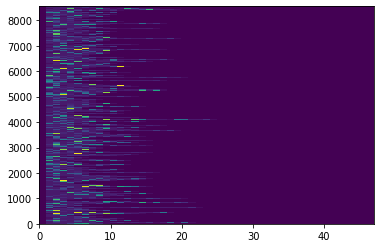

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

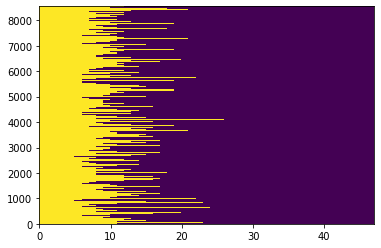

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

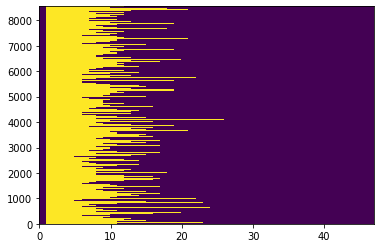

In [ ]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.ones_like(sentence1)
input_type_ids = tf.concat([type_cls, type_s1], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### Putting it all together

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
  input_word_ids = tf.concat([cls, sentence], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s = tf.ones_like(sentence)
  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [ ]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (8551, 47)
input_mask      shape: (8551, 47)
input_type_ids  shape: (8551, 47)
glue_train_labels shape: (8551,)


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

### Custom classifier model:
* Obviously first layer is BERT encoder
* Afterwards there are few droppot and dense layers for the classifiction task.
* the encoder outputs to arrays, array at index 1 is fed to downstream layers.

In [ ]:
class MyModel(tf.keras.Model):

  def __init__(self, encoder):
    super(MyModel, self).__init__()
    self.encoder = encoder
    self.dout=Dropout(0.2)
    self.fc_1 = Dense(768, activation='relu')
    self.dout2=Dropout(0.2)
    self.fc_2 = Dense(128, activation='relu')
    self.classfier = Dense(2, activation='softmax')

  def call(self, inputs):
    x = self.encoder(inputs)
    x = self.dout(x[1])
    x = self.fc_1(x)
    x = self.dout2(x)
    x = self.fc_2(x)
    return self.classfier(x)

In [ ]:
bert_encoder = bert.bert_models.get_transformer_encoder(bert_config,)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
bert_classifier = MyModel(bert_encoder)

In [ ]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

#### Model training.

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/5
268/268 [==============================] - 2794s 10s/step - loss: 0.6086 - accuracy: 0.6894 - val_loss: 0.4783 - val_accuracy: 0.7958
Epoch 2/5
268/268 [==============================] - 2557s 10s/step - loss: 0.3997 - accuracy: 0.8317 - val_loss: 0.4184 - val_accuracy: 0.8255
Epoch 3/5
268/268 [==============================] - 2597s 10s/step - loss: 0.2532 - accuracy: 0.9060 - val_loss: 0.5008 - val_accuracy: 0.8207
Epoch 4/5
268/268 [==============================] - 2532s 9s/step - loss: 0.1812 - accuracy: 0.9367 - val_loss: 0.6625 - val_accuracy: 0.8236
Epoch 5/5
268/268 [==============================] - 2509s 9s/step - loss: 0.1240 - accuracy: 0.9580 - val_loss: 0.6829 - val_accuracy: 0.8313


#### Evalutaion:
* Used own sample o test.
* The test split of the data set is incomeplete, as the labels are having only -1s. We can only predct with the dataset.

In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'Imagination is more important than knowledge.',
            'Arnab is a good boy. ain''t he?', 'Arnab good is are boy.'],
    },
    tokenizer=tokenizer)

In [ ]:
result = bert_classifier(my_examples, training=False)
print(result)
result = tf.argmax(result, axis=-1).numpy()
print("Final result of own example is",result)

tf.Tensor(
[[0.00255049 0.99744946]
 [0.00494097 0.995059  ]
 [0.9944723  0.00552767]], shape=(3, 2), dtype=float32)
Final result of own example is [1 1 0]


In [ ]:
testResult = bert_classifier(glue_test, training = False)
testResult = tf.argmax(testResult, axis=-1).numpy()
print("Final test result of test split is",testResult)

Final test result of test split is [1 1 1 ... 0 1 1]


In [ ]:
print(bert_encoder(my_examples)[0].shape)
print(bert_encoder(my_examples)[1].shape)

(3, 14, 768)
(3, 768)


In [ ]:
bert_classifier.layers[0].trainable

True

## Questions & Answers:
1. **What is the tutorial classifying when using the GLUE MRPC data set?**
> The tutorial classifies whether each pair captures a paraphrase/semantic equivalence relationship or not.

2. **In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model.
Is this necessary for the data set single sentence classification?**
> input mask is necessary. Bert encoder uses bidirectional LSTM with self attention. So, its important for the encoder to know where the real tokens are and where are the paddings in a given input squence(first sentence). Whereas input type id mask differentiates between the tokens for first and second sentence. In our task it is optional.

3. **How does the tokenization in BERT differ from the one in the previous Task 5?**
> Its not just a word based tokenizer. Its different form the previous one in following ways-
>* First of all, as the tutorial says, its a python based tokennizer, not a tensorflow layer.
>* the tokenizer makes all the words lower case.
>* divide words into smaller sub-word units, like our example ['hello', 'bert', '##en', '##code', '##r', '!'], When it breaks a word it add '##' in front
>* it encodes punctuation marks.
>* It also has special encoding for [CLS] and [SEP]
>* Theory says, the vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added.

4. **What is a [CLS] token and what is it used for?**
> This is the first token to the sequence it indicates whether this is a classification task. so if this is there, the encoder outputs a list of two array. First array consisists of embedding of each token of each sequence. The spae is (batchSize, maxlen, 768). And the second array consists a embedding for the whole sequence for downstream classification task.The shape is (batchSize, 768). This second part can be used in downstream classification task to make it faster.

5. **Which part of the BERT encoding is used for the classification?**
> The second part of the BERT encoding is used for classification. The encoder outputs a list of two array. First array consisists of embedding of each token of each sequence. The spae is (batchSize, maxlen, 768). And the second array consists a embedding for the whole sequence for downstream classification task.The shape is (batchSize, 768). This second part can be used in downstream classification task to make it faster.

6. **Are the BERT encoder weights also fine-tuned to the task?**
> Yes, the encoder weights also get fine tuned.
